In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [14, 8]

from datasets import Dataset, load_dataset, concatenate_datasets
import gc
import os
import pyarrow as pa
import re
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from tqdm.auto import trange
from typing import Iterator, List
import pickle

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, Sampler
from transformers import AutoTokenizer, AutoModel

from custom_classes import ContrastSampler, DataManager, Trainer, TrainerA, WeightedCosineSimilarityLoss, ContrastLoss2
from custom_classes import INT2LABEL as categories

Loaded WeightedCosineSimilarityLoss...
Loaded ContrastSampler...
Loaded Trainer...
Loaded TrainerA...
Loaded TrainerB...
Loaded DataManager...


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [3]:
data_path = '../input/semeval-data'
DEV = True
model_name = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
model_sampler = 'random'
N_EPOCHS = 1000
N_EPOCHS_BEFORE_MULTILANG_FINETUNE = 10
N_EPOCHS_BEFORE_FINETUNE = 50
N_FINETUNE_EPOCHS = 50
N_POST_FINETUNE_EPOCHS = 50
MODEL_BATCH_SIZE = 26
HEAD_BATCH_SIZE = 200
MIN_SAMPLES_FROM_CLASS = 1
HEAD_LR = 1e-3
HEAD_GAMMA = .99
MODEL_LR = 2e-5
BETA = 0.01
MODEL_GAMMA = .98

VALIDATE_EVERY = 1
CHECKPOINT_EVERY = 10
EARLIEST_CHECKPOINT = 1000

In [4]:
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
all_langs = ['en', 'ge', 'fr', 'it', 'ru', 'po']
datamanager = DataManager(
    tokenizer=tokenizer,
    data_dir=data_path,
    use_dev=DEV,
    languages_for_head_eval=all_langs,
    languages_for_head_train=all_langs,
    languages_for_contrastive=all_langs,
)
N_CLASSES = datamanager.num_classes
metrics = list()
reference_list = list()

In [5]:
EMBEDDING_DIM = model.embeddings.word_embeddings.embedding_dim
head = nn.Sequential(
    nn.Linear(EMBEDDING_DIM, 256),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(256, N_CLASSES),
    nn.Dropout(),
)

In [6]:
dataset_contrastive = datamanager.get_contrastive_dataset()
dataset_head_train = datamanager.get_head_train_dataset()
dataset_head_eval = datamanager.get_head_eval_dataset()
trainer = TrainerA(
    model=model,
    head=head,
    device=device,
    head_loss=nn.BCEWithLogitsLoss(),
    model_loss=WeightedCosineSimilarityLoss(N_CLASSES),
    model_dataset=dataset_contrastive,
    head_dataset=dataset_head_train,
    eval_dataset=dataset_head_eval,        
    n_classes=N_CLASSES,
    model_loader_type=model_sampler,
    train_head_batch_size=HEAD_BATCH_SIZE,
    train_model_batch_size=MODEL_BATCH_SIZE,
    head_lr=HEAD_LR,
    model_lr=MODEL_LR,
    head_gamma=HEAD_GAMMA,
    model_gamma=MODEL_GAMMA,
    beta=BETA,
    min_samples_from_class=MIN_SAMPLES_FROM_CLASS,
    validate_every_n_epochs=VALIDATE_EVERY,
    checkpoint_every_n_epochs=CHECKPOINT_EVERY,
    earliest_checkpoint=EARLIEST_CHECKPOINT,
)

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-8acb786ec29a7c2b/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8. Subsequent calls will reuse this data.
Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-1a7673e91cc08d2e/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8. Subsequent calls will reuse this data.
Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-c40877d40590cae6/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8. Subsequent calls will reuse this data.
Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-a87f5be4f2f143fd/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8. Subsequent calls will reuse this data.
Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-b19b6bdccea42e7b/0.0.0/4b86d314f7236db91f0a0f5cda32d4

# Train Full

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

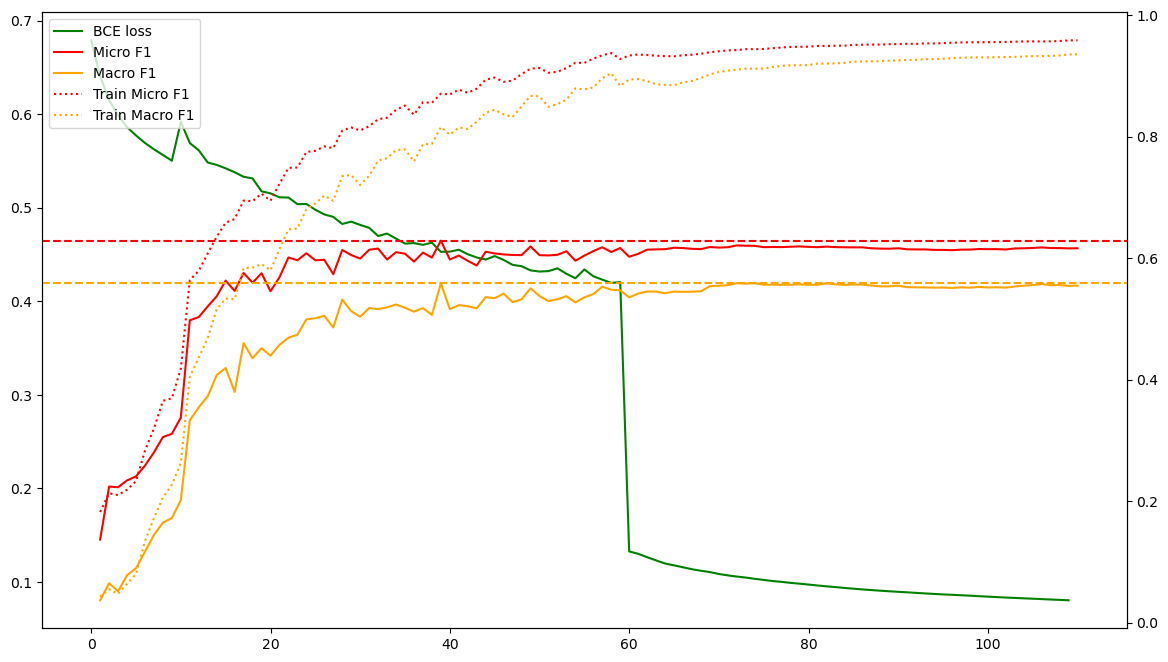

MicroF1:  0.6286571621894836  @  38
MacroF1:  0.558700442314148  @  73
MacroF1:  0.5583735704421997  @  38


In [7]:
reference_list.append(dataset_head_eval)
trainer.train_head(N_EPOCHS_BEFORE_MULTILANG_FINETUNE)
trainer.train_joint(N_FINETUNE_EPOCHS)
trainer.train_head(N_POST_FINETUNE_EPOCHS)
trainer.save_checkpoint('joint-multilang-random-nodev-50', 49)
trainer.save_hparams('joint-multilang-random-nodev-50-params')
trainer.save_log_dict('joint-multilang-random-nodev-50-logdict')
metrics.append(trainer.log_dict)
trainer.plot_metrics(trainer.log_dict, VALIDATE_EVERY)

In [8]:
# Sanity Check
langs = all_langs
for lang in langs:
    dataset_sanity = datamanager._get_single_named_dataset(lang, dev=True)
    dataset_sanity = datamanager._preprocess_head_dataset(dataset_sanity)
    embeddings = trainer.compute_embeddings(dataset_sanity)
    predictions = trainer.predict(embeddings.tensors[0], 'cpu')
    f1 = f1_score(dataset_sanity['labels'], predictions, average='micro')
    print(lang, ': ', f1)

en :  0.6814621409921671
ge :  0.5734597156398104
fr :  0.6178343949044586
it :  0.5714285714285714
ru :  0.5345622119815668
po :  0.6391752577319587


# Train Random Sampler

In [9]:
lang = 'en'
metrics = []
datamanager = DataManager(
    tokenizer=tokenizer,
    data_dir=data_path,
    use_dev=DEV,
    languages_for_head_eval=[lang],
    languages_for_head_train=[lang],
    languages_for_contrastive=[lang],
)
dataset_contrastive = datamanager.get_contrastive_dataset()
dataset_head_train = datamanager.get_head_train_dataset()
dataset_head_eval = datamanager.get_head_eval_dataset()

for seed in trange(42, 52):
    trainer = TrainerA(
        model=model,
        head=head,
        device=device,
        head_loss=nn.BCEWithLogitsLoss(),
        model_loss=WeightedCosineSimilarityLoss(N_CLASSES),
        model_dataset=dataset_contrastive,
        head_dataset=dataset_head_train,
        eval_dataset=dataset_head_eval,        
        n_classes=N_CLASSES,
        model_loader_type='random',
        train_head_batch_size=HEAD_BATCH_SIZE,
        train_model_batch_size=MODEL_BATCH_SIZE,
        head_lr=HEAD_LR,
        model_lr=MODEL_LR,
        head_gamma=HEAD_GAMMA,
        model_gamma=MODEL_GAMMA,
        beta=BETA,
        min_samples_from_class=MIN_SAMPLES_FROM_CLASS,
        validate_every_n_epochs=VALIDATE_EVERY,
        checkpoint_every_n_epochs=CHECKPOINT_EVERY,
        earliest_checkpoint=10000,
    )


    # Loading checkpoint
    trainer.load_from_checkpoint('joint-multilang-random-nodev-50')
    head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, 256),
        nn.Dropout(),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.Dropout(),
        nn.ReLU(),
        nn.Linear(256, N_CLASSES),
        nn.Dropout(),
    )
    head_optimizer = AdamW(head.parameters(), lr=HEAD_LR)
    trainer.set_head(head, head_optimizer)


    # Training
    trainer.train_head(N_EPOCHS_BEFORE_FINETUNE, random_seed=seed)
    trainer.train_joint(N_FINETUNE_EPOCHS, random_seed=seed)
    trainer.train_head(N_POST_FINETUNE_EPOCHS, random_seed=seed)
    metrics.append(trainer.log_dict)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

In [10]:
print(f'Average Max MicroF1: {np.mean(np.array([np.max(m["microf1"]) for m in metrics]))}')
print(f'Average Max MacroF1: {np.mean(np.array([np.max(m["macrof1"]) for m in metrics]))}')
print(f'Average Max Train MicroF1: {np.mean(np.array([np.max(m["train_microf1"]) for m in metrics]))}')
print(f'Average Max Train MacroF1: {np.mean(np.array([np.max(m["train_macrof1"]) for m in metrics]))}')

print(f'Average Last MicroF1: {np.mean(np.array([m["microf1"][-1] for m in metrics]))}')
print(f'Average Last MacroF1: {np.mean(np.array([m["macrof1"][-1] for m in metrics]))}')
print(f'Average Last Train MicroF1: {np.mean(np.array([m["train_microf1"][-1] for m in metrics]))}')
print(f'Average Last Train MacroF1: {np.mean(np.array([m["train_macrof1"][-1] for m in metrics]))}')

Average Max MicroF1: 0.7028494358062745
Average Max MacroF1: 0.5111620903015137
Average Max Train MicroF1: 0.9795486629009247
Average Max Train MacroF1: 0.9376711905002594
Average Last MicroF1: 0.688461858034134
Average Last MacroF1: 0.4930924326181412
Average Last Train MicroF1: 0.9793118536472321
Average Last Train MacroF1: 0.9339845240116119


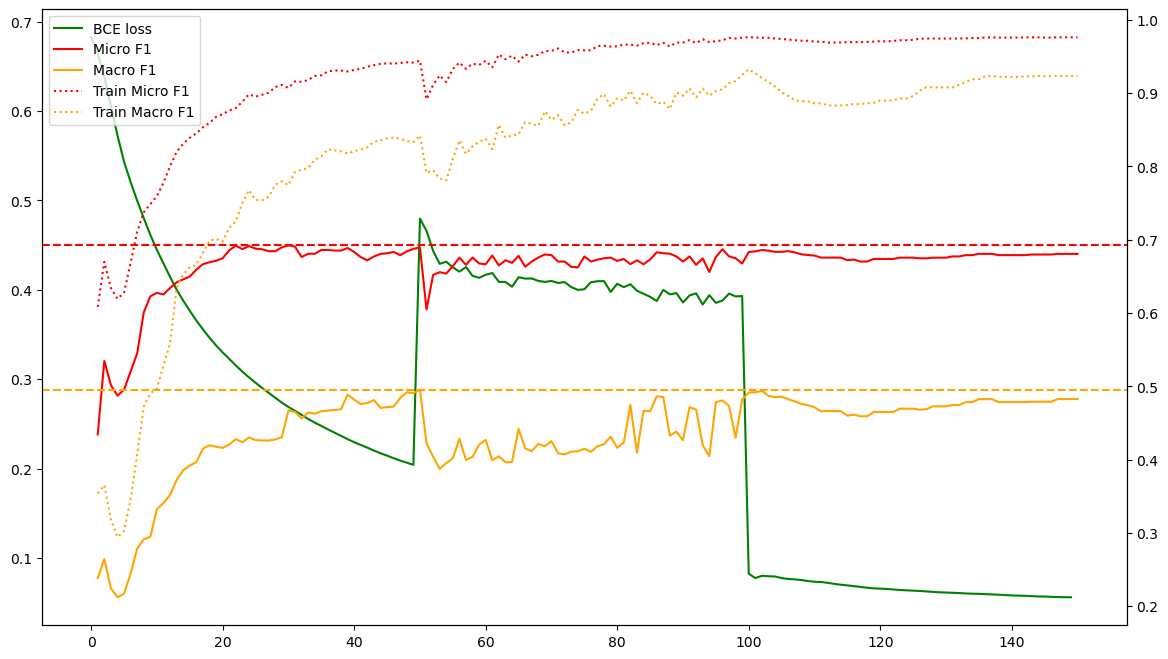

MicroF1:  0.6924101114273071  @  29
MacroF1:  0.4955764412879944  @  49
MacroF1:  0.46698516607284546  @  29


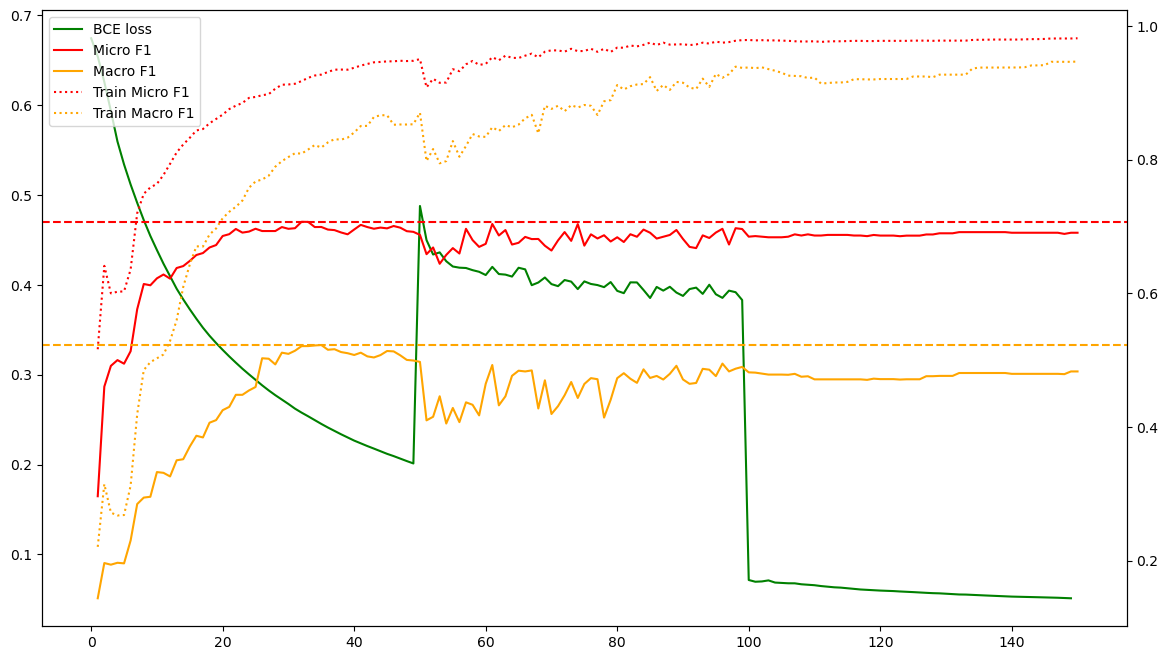

MicroF1:  0.7069644927978516  @  31
MacroF1:  0.5225650072097778  @  34
MacroF1:  0.5209072232246399  @  31


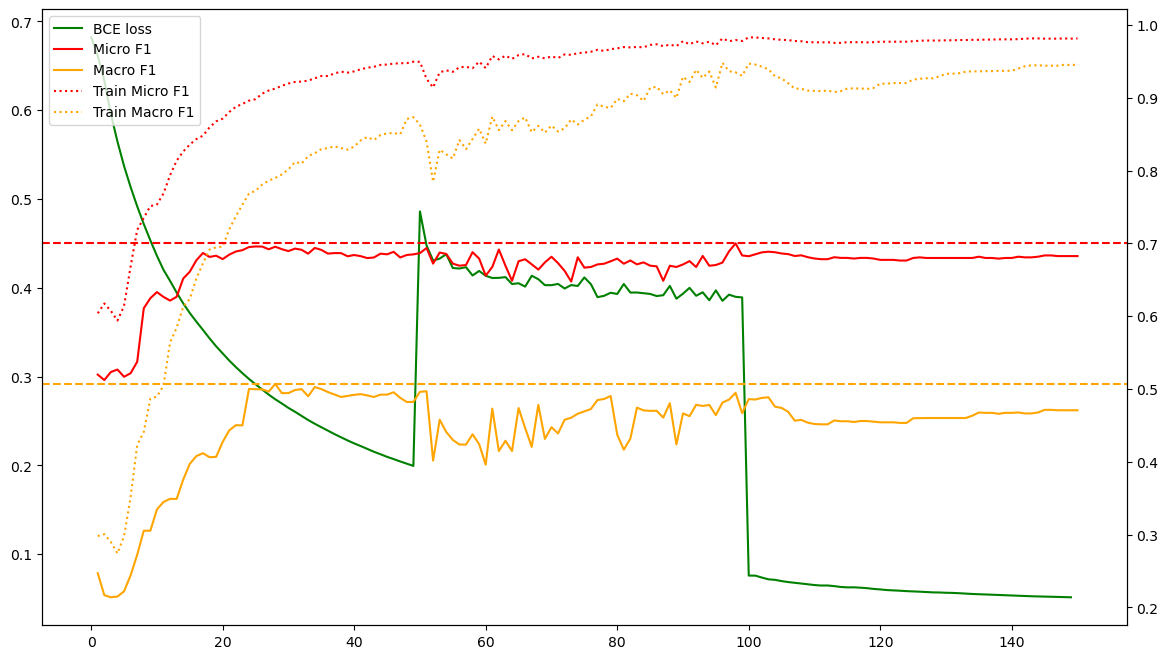

MicroF1:  0.699999988079071  @  97
MacroF1:  0.5068960189819336  @  27
MacroF1:  0.49467146396636963  @  97


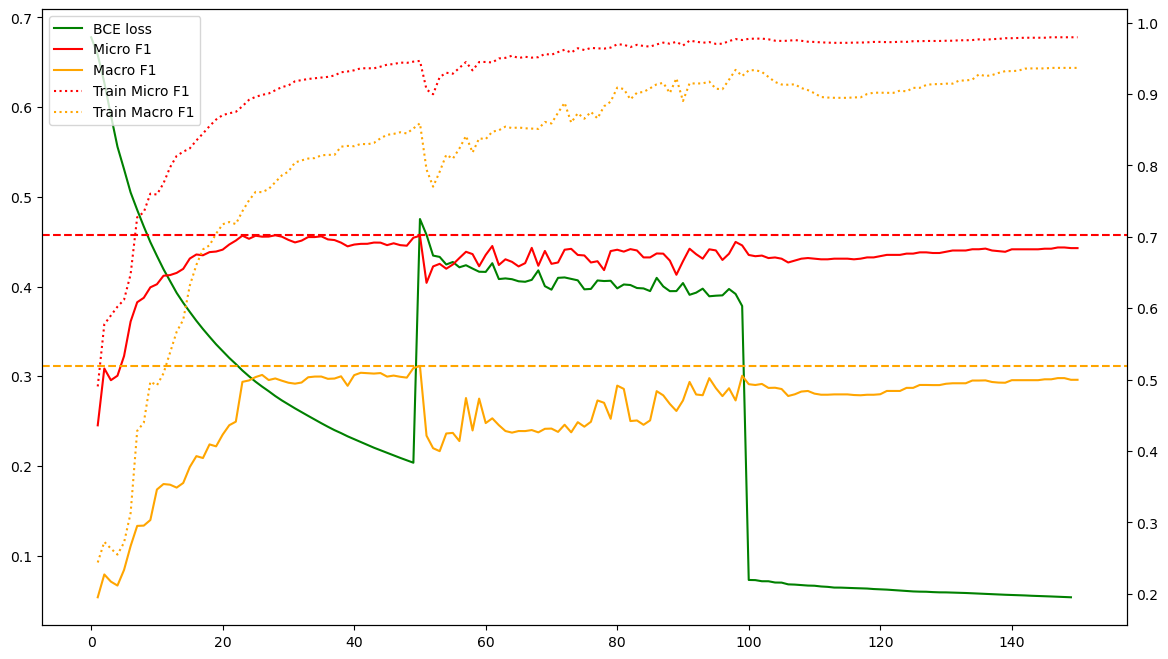

MicroF1:  0.7021276354789734  @  27
MacroF1:  0.5189715623855591  @  49
MacroF1:  0.5016232132911682  @  27


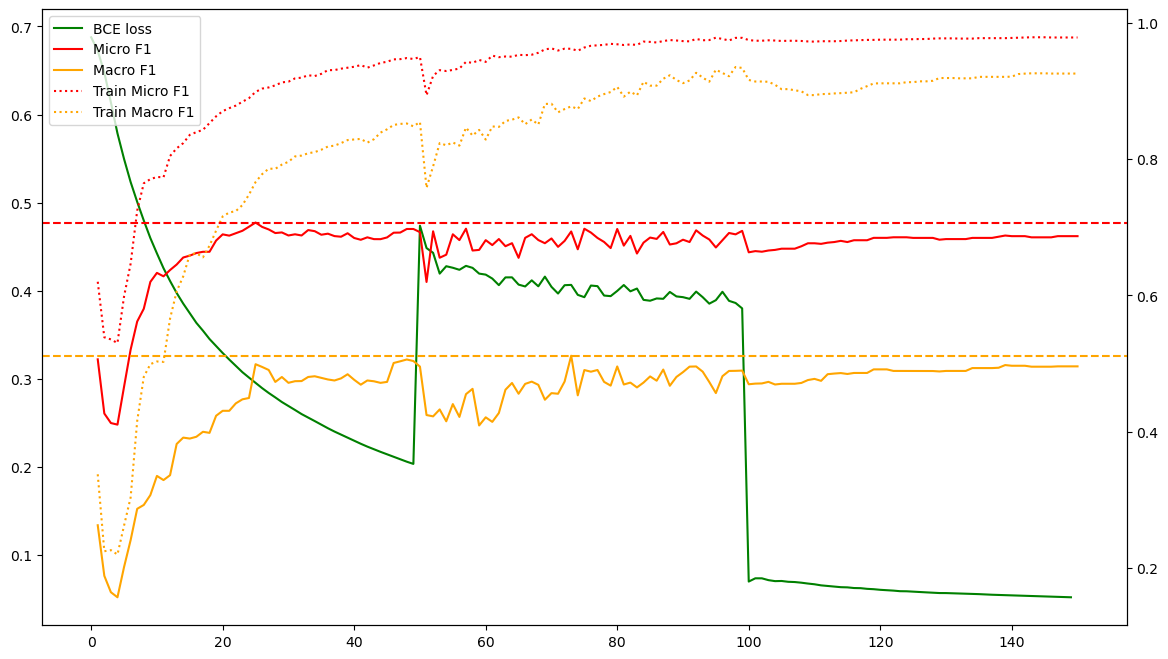

MicroF1:  0.7068272829055786  @  24
MacroF1:  0.5114409923553467  @  72
MacroF1:  0.4989384710788727  @  24


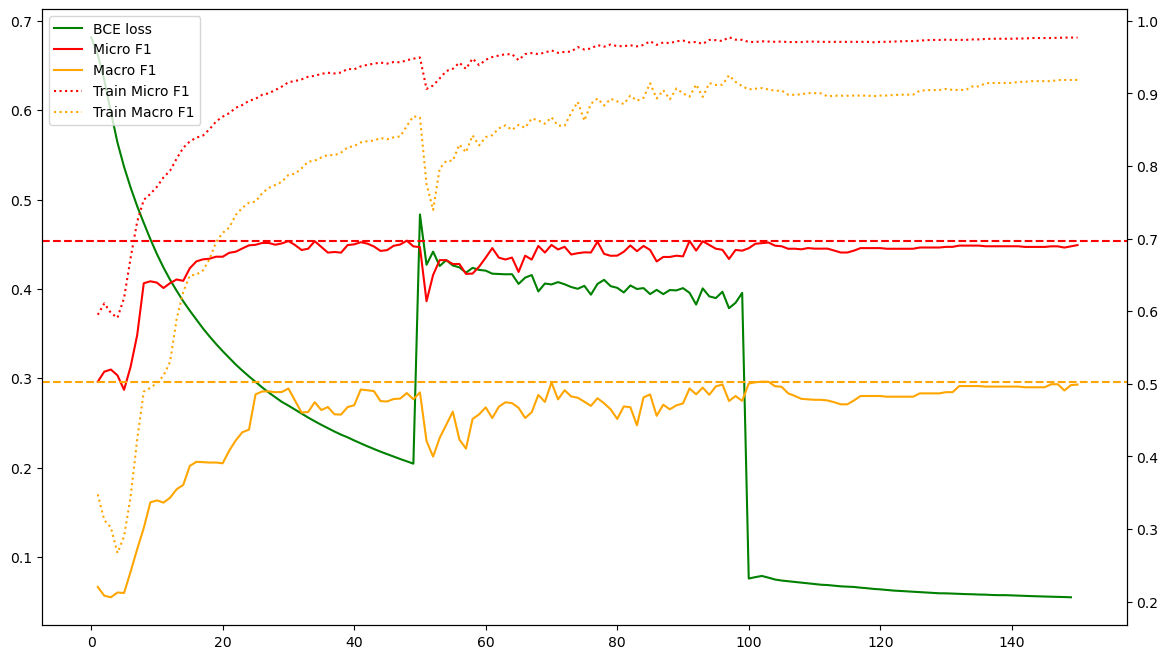

MicroF1:  0.6971279382705688  @  47
MacroF1:  0.5028790831565857  @  101
MacroF1:  0.48720991611480713  @  47


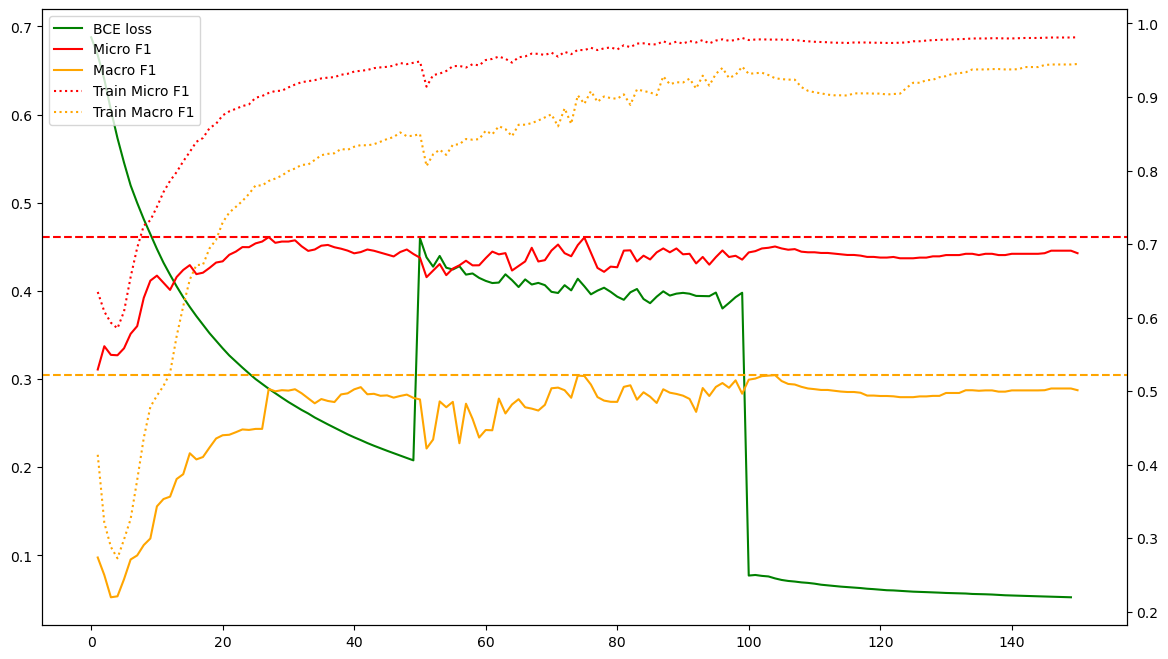

MicroF1:  0.7094240784645081  @  26
MacroF1:  0.5217640399932861  @  103
MacroF1:  0.5029742121696472  @  26


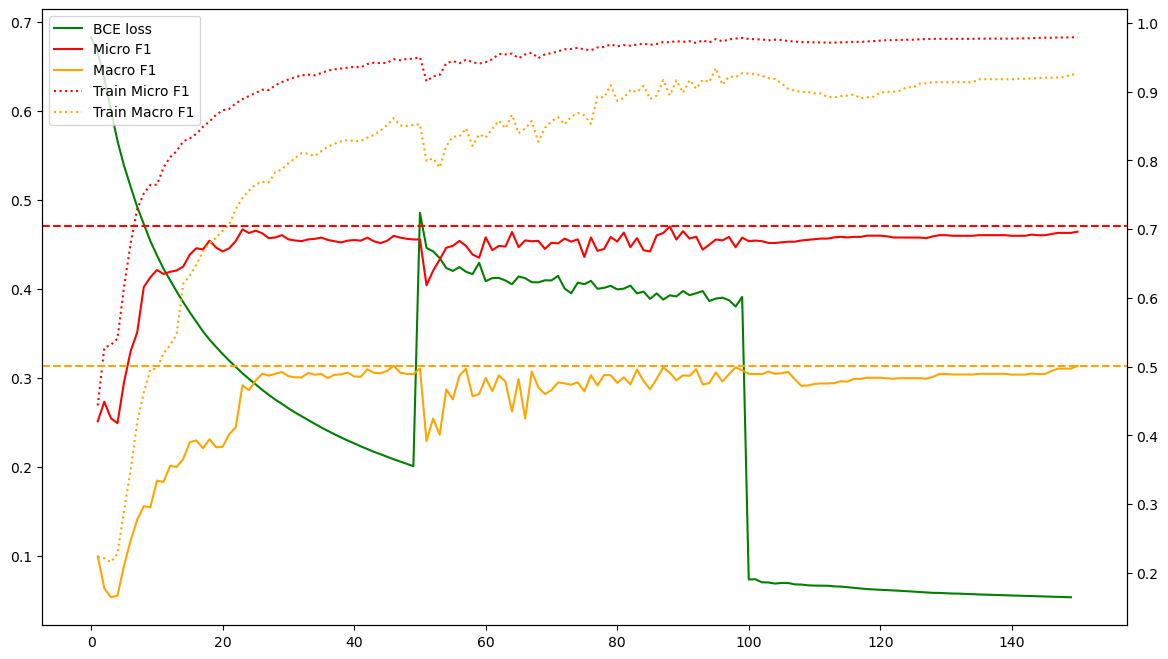

MicroF1:  0.7038512825965881  @  87
MacroF1:  0.5013183355331421  @  45
MacroF1:  0.490996390581131  @  87


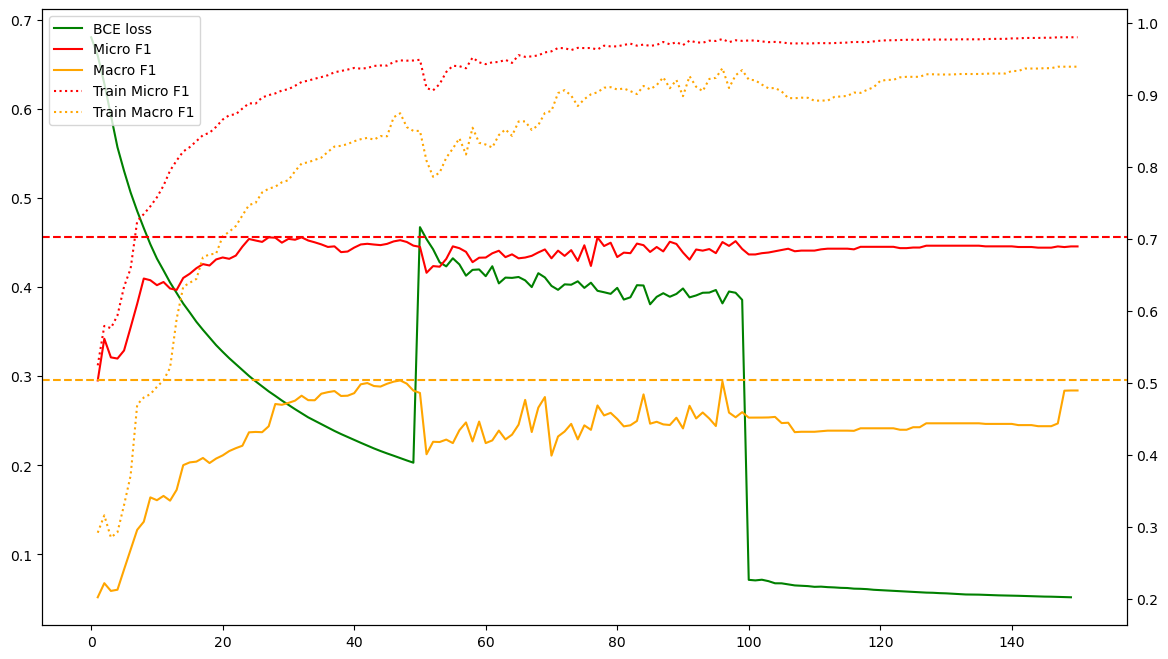

MicroF1:  0.7019867300987244  @  26
MacroF1:  0.5033577680587769  @  46
MacroF1:  0.43977034091949463  @  26


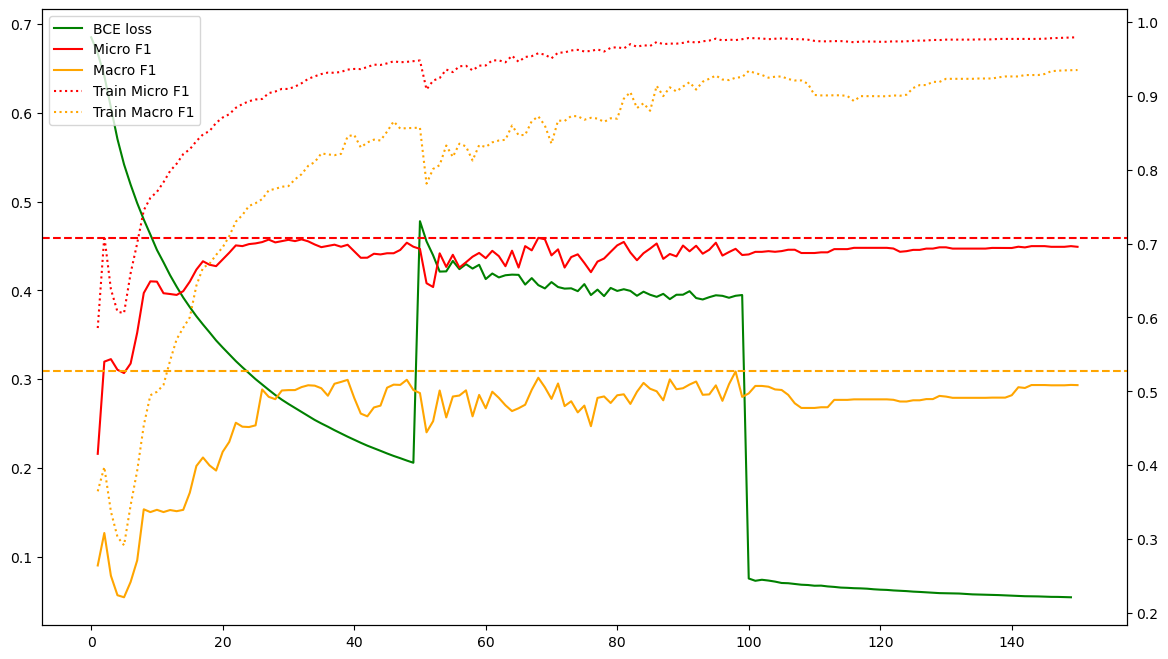

MicroF1:  0.707774817943573  @  67
MacroF1:  0.5268516540527344  @  97
MacroF1:  0.5183649063110352  @  67


In [11]:
for log_dict in metrics:
    TrainerA.plot_metrics(log_dict, 1)

In [12]:
with open('metrics_random.pickle', 'wb') as f:
    pickle.dump(metrics, f)

# Train Contrast Sampler

In [13]:
lang = 'en'
metrics = []
datamanager = DataManager(
    tokenizer=tokenizer,
    data_dir=data_path,
    use_dev=DEV,
    languages_for_head_eval=[lang],
    languages_for_head_train=[lang],
    languages_for_contrastive=[lang],
)
dataset_contrastive = datamanager.get_contrastive_dataset()
dataset_head_train = datamanager.get_head_train_dataset()
dataset_head_eval = datamanager.get_head_eval_dataset()

for seed in trange(42, 52):
    trainer = TrainerA(
        model=model,
        head=head,
        device=device,
        head_loss=nn.BCEWithLogitsLoss(),
        model_loss=WeightedCosineSimilarityLoss(N_CLASSES),
        model_dataset=dataset_contrastive,
        head_dataset=dataset_head_train,
        eval_dataset=dataset_head_eval,        
        n_classes=N_CLASSES,
        model_loader_type='contrast',
        train_head_batch_size=HEAD_BATCH_SIZE,
        train_model_batch_size=MODEL_BATCH_SIZE,
        head_lr=HEAD_LR,
        model_lr=MODEL_LR,
        head_gamma=HEAD_GAMMA,
        model_gamma=MODEL_GAMMA,
        beta=BETA,
        min_samples_from_class=MIN_SAMPLES_FROM_CLASS,
        validate_every_n_epochs=VALIDATE_EVERY,
        checkpoint_every_n_epochs=CHECKPOINT_EVERY,
        earliest_checkpoint=10000,
    )


    # Loading checkpoint
    trainer.load_from_checkpoint('joint-multilang-random-nodev-50')
    head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, 256),
        nn.Dropout(),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.Dropout(),
        nn.ReLU(),
        nn.Linear(256, N_CLASSES),
        nn.Dropout(),
    )
    head_optimizer = AdamW(head.parameters(), lr=HEAD_LR)
    trainer.set_head(head, head_optimizer)


    # Training
    trainer.train_head(N_EPOCHS_BEFORE_FINETUNE, random_seed=seed)
    trainer.train_joint(N_FINETUNE_EPOCHS, random_seed=seed)
    trainer.train_head(N_POST_FINETUNE_EPOCHS, random_seed=seed)
    metrics.append(trainer.log_dict)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

In [14]:
print(f'Average Max MicroF1: {np.mean(np.array([np.max(m["microf1"]) for m in metrics]))}')
print(f'Average Max MacroF1: {np.mean(np.array([np.max(m["macrof1"]) for m in metrics]))}')
print(f'Average Max Train MicroF1: {np.mean(np.array([np.max(m["train_microf1"]) for m in metrics]))}')
print(f'Average Max Train MacroF1: {np.mean(np.array([np.max(m["train_macrof1"]) for m in metrics]))}')

print(f'Average Last MicroF1: {np.mean(np.array([m["microf1"][-1] for m in metrics]))}')
print(f'Average Last MacroF1: {np.mean(np.array([m["macrof1"][-1] for m in metrics]))}')
print(f'Average Last Train MicroF1: {np.mean(np.array([m["train_microf1"][-1] for m in metrics]))}')
print(f'Average Last Train MacroF1: {np.mean(np.array([m["train_macrof1"][-1] for m in metrics]))}')

Average Max MicroF1: 0.7054748117923737
Average Max MacroF1: 0.520171058177948
Average Max Train MicroF1: 0.987647932767868
Average Max Train MacroF1: 0.9645107448101043
Average Last MicroF1: 0.6913154006004334
Average Last MacroF1: 0.49754206240177157
Average Last Train MicroF1: 0.9875203430652618
Average Last Train MacroF1: 0.9635343909263611


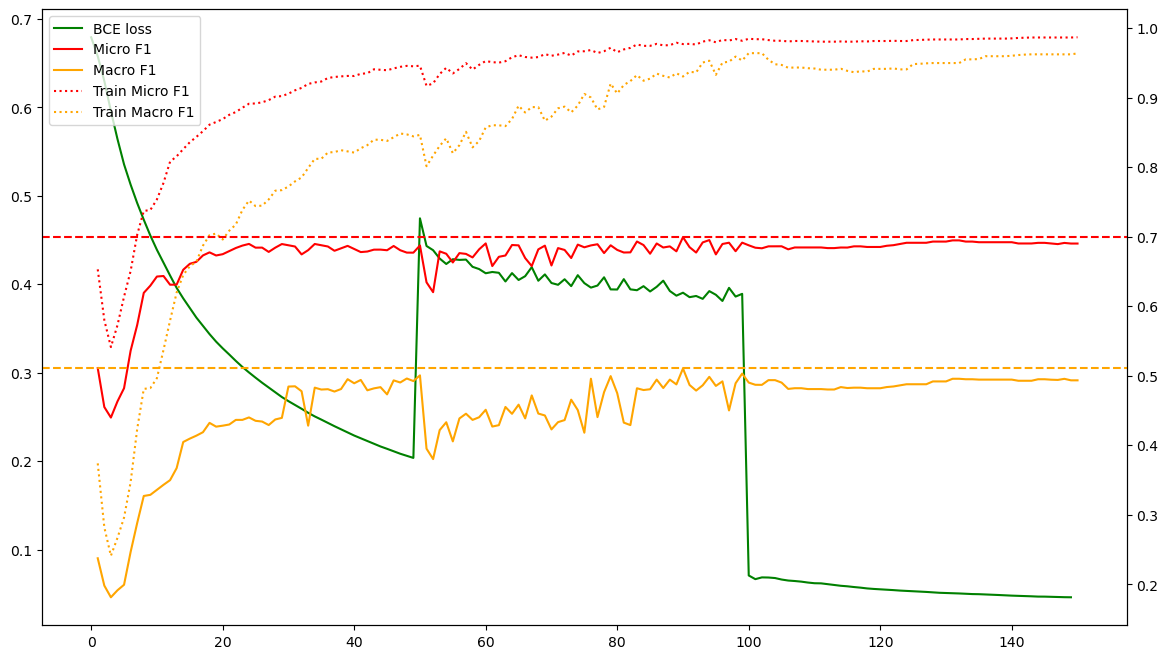

MicroF1:  0.6993377208709717  @  89
MacroF1:  0.5104668140411377  @  89
MacroF1:  0.5104668140411377  @  89


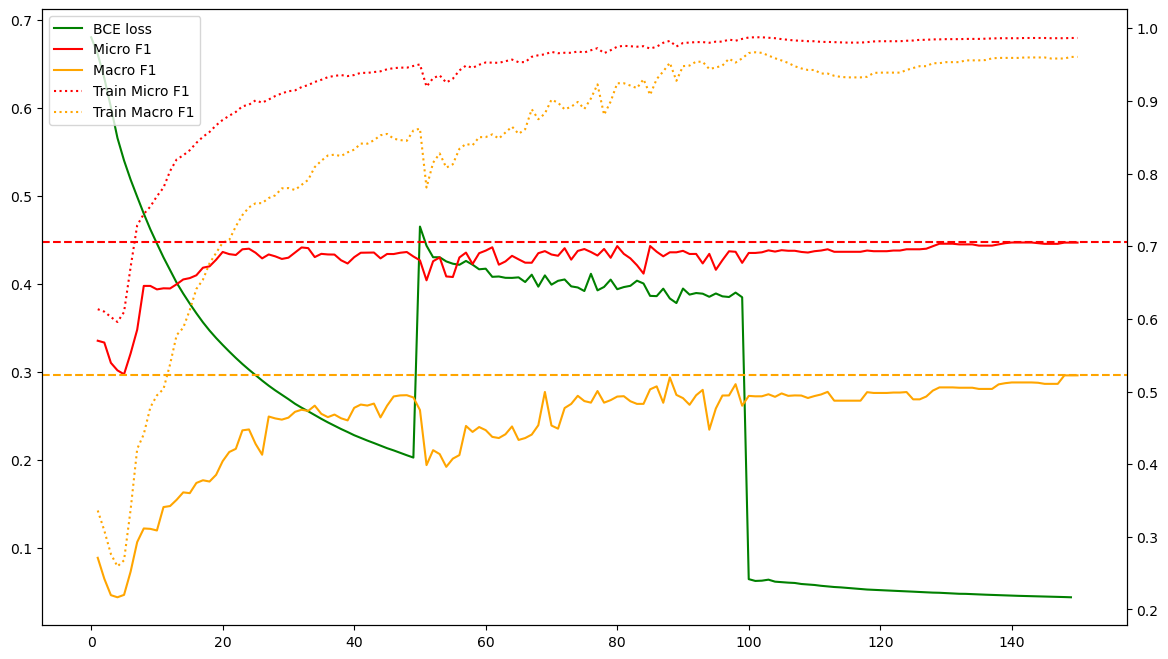

MicroF1:  0.7051113843917847  @  139
MacroF1:  0.5222253799438477  @  147
MacroF1:  0.5124698877334595  @  139


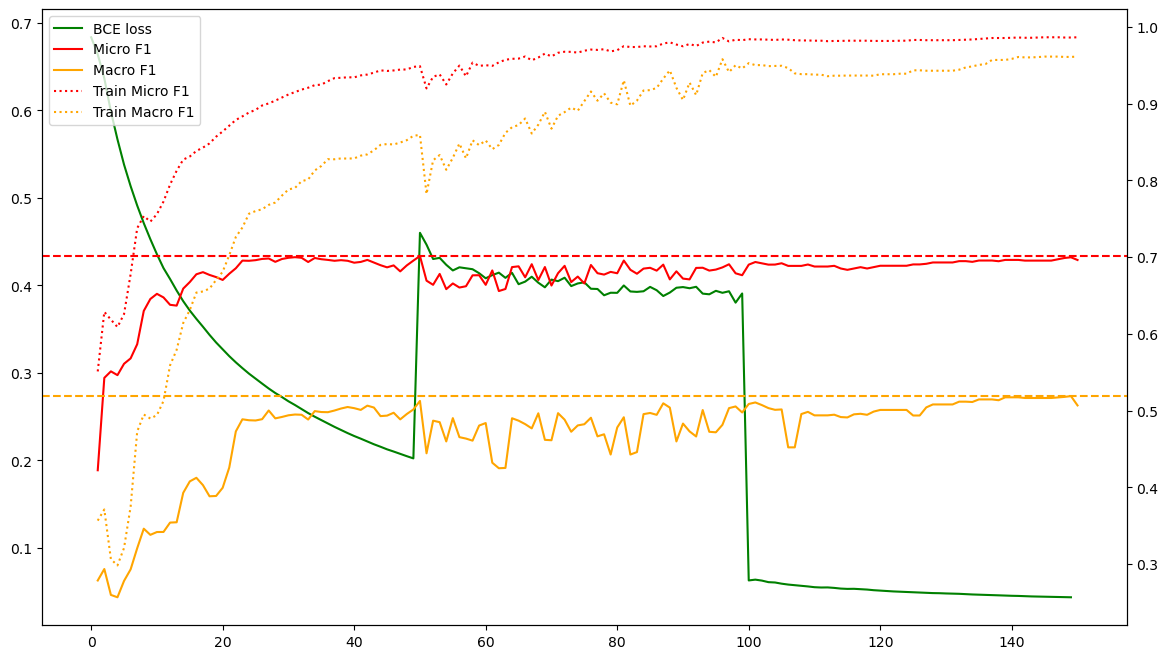

MicroF1:  0.7015706896781921  @  49
MacroF1:  0.5189638137817383  @  148
MacroF1:  0.5126926898956299  @  49


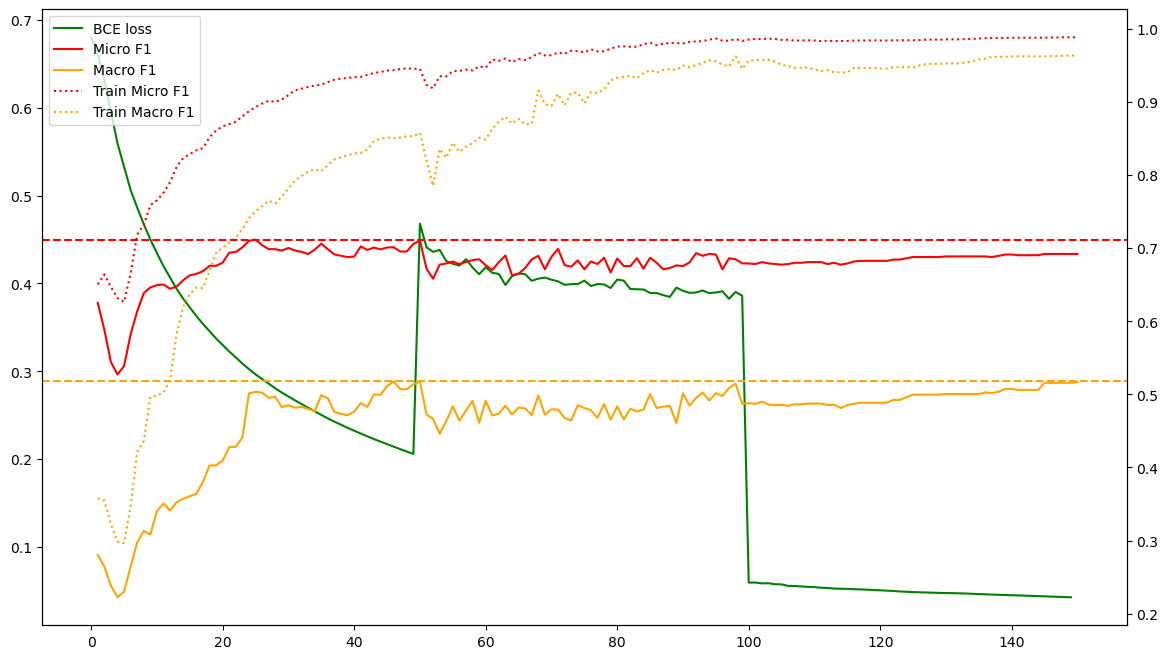

MicroF1:  0.7117726802825928  @  24
MacroF1:  0.5176535844802856  @  45
MacroF1:  0.50340336561203  @  24


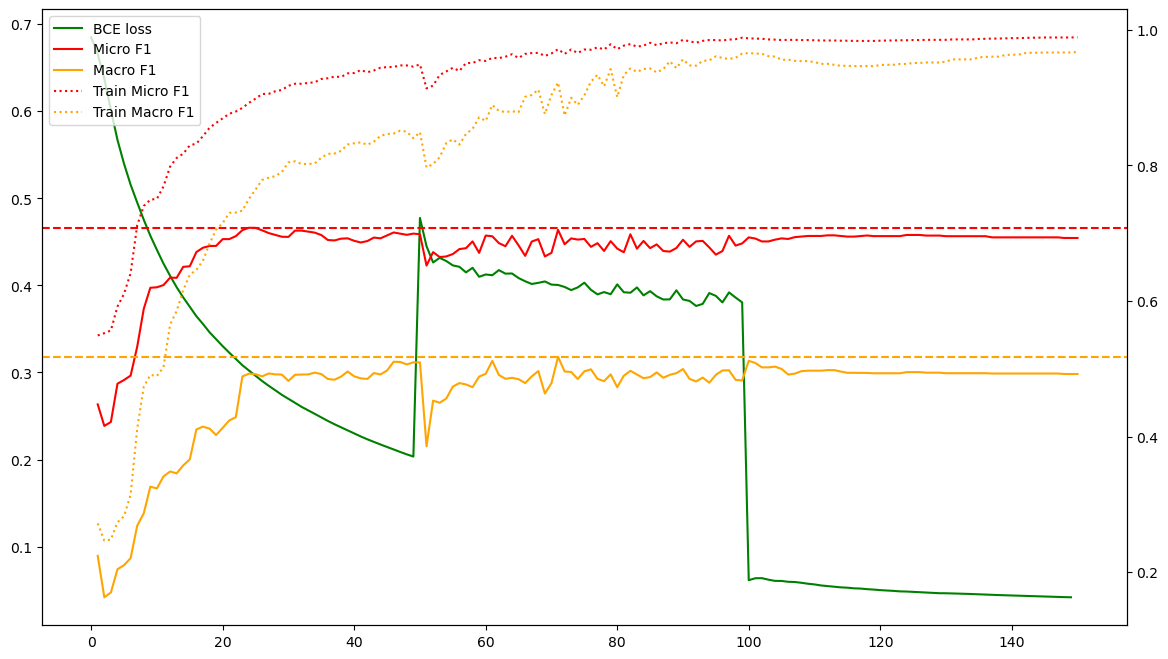

MicroF1:  0.708108127117157  @  23
MacroF1:  0.5176982879638672  @  70
MacroF1:  0.4928598701953888  @  23


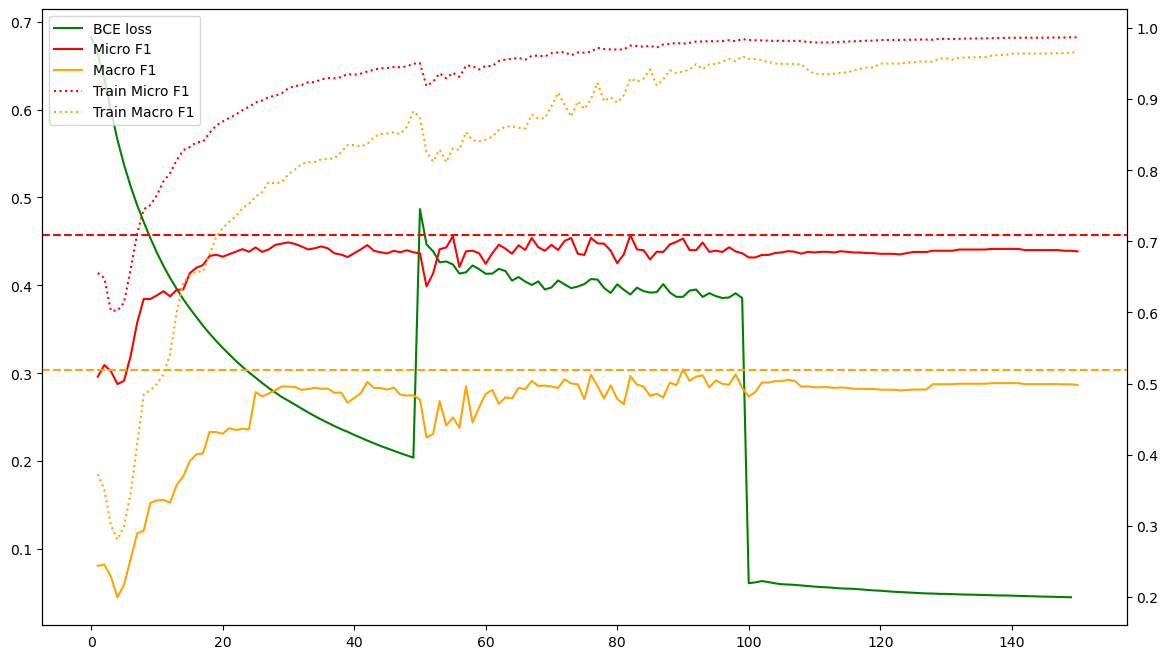

MicroF1:  0.7090908885002136  @  81
MacroF1:  0.5197241306304932  @  89
MacroF1:  0.5106126070022583  @  81


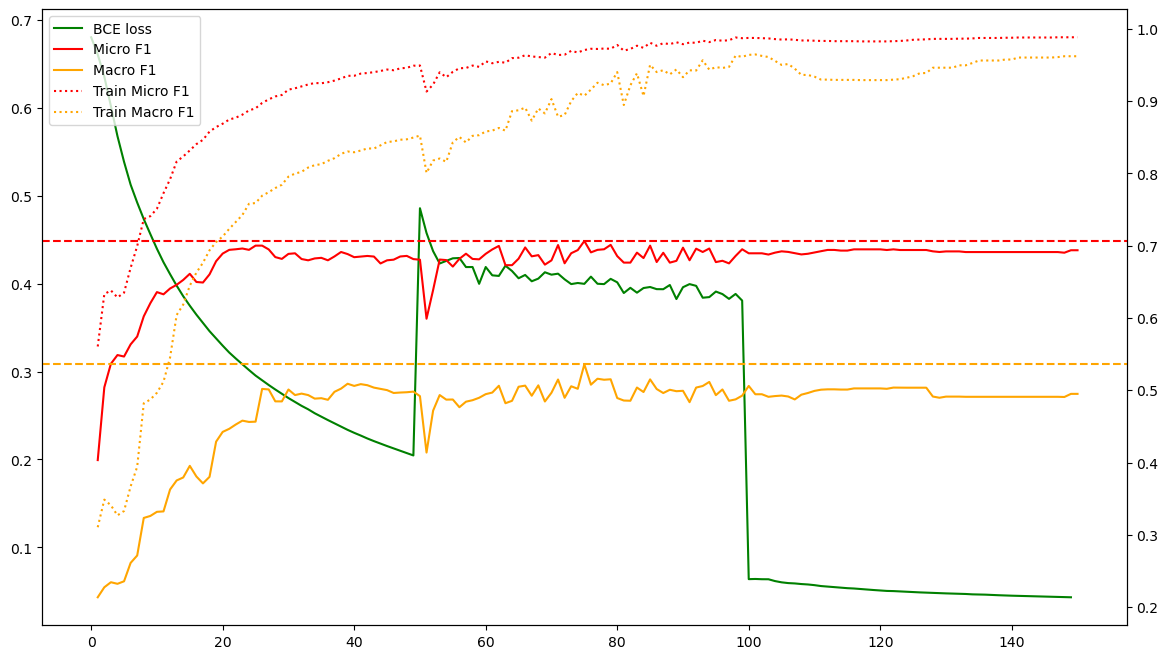

MicroF1:  0.7063389420509338  @  74
MacroF1:  0.5358556509017944  @  74
MacroF1:  0.5358556509017944  @  74


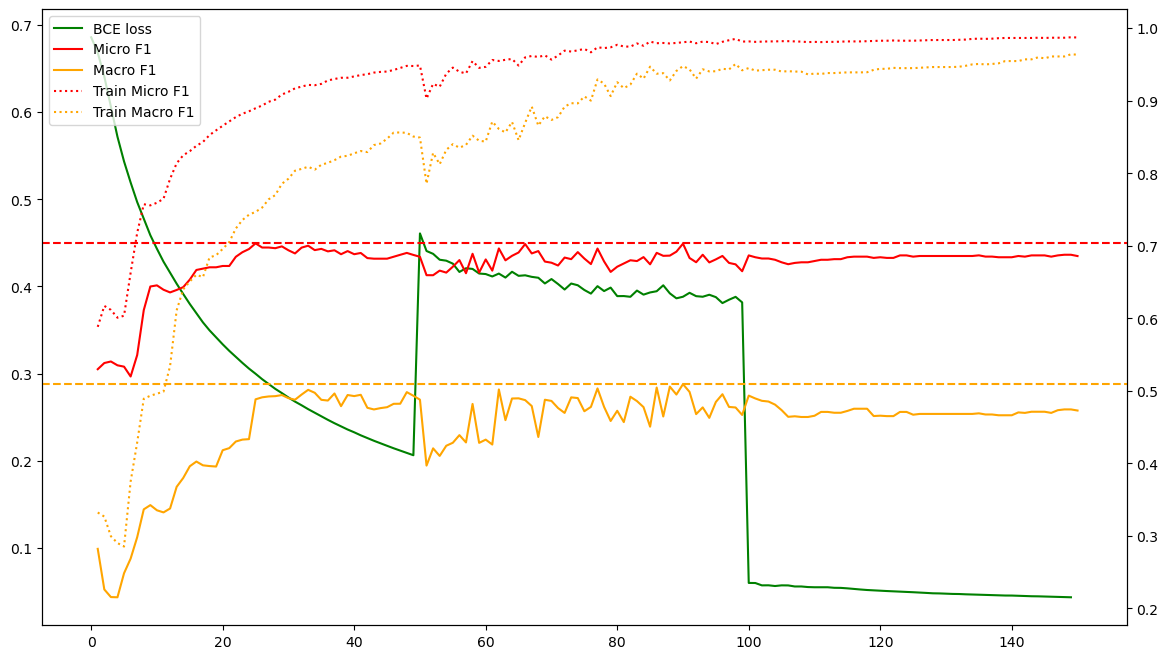

MicroF1:  0.7033557295799255  @  24
MacroF1:  0.5091871023178101  @  89
MacroF1:  0.4882650673389435  @  24


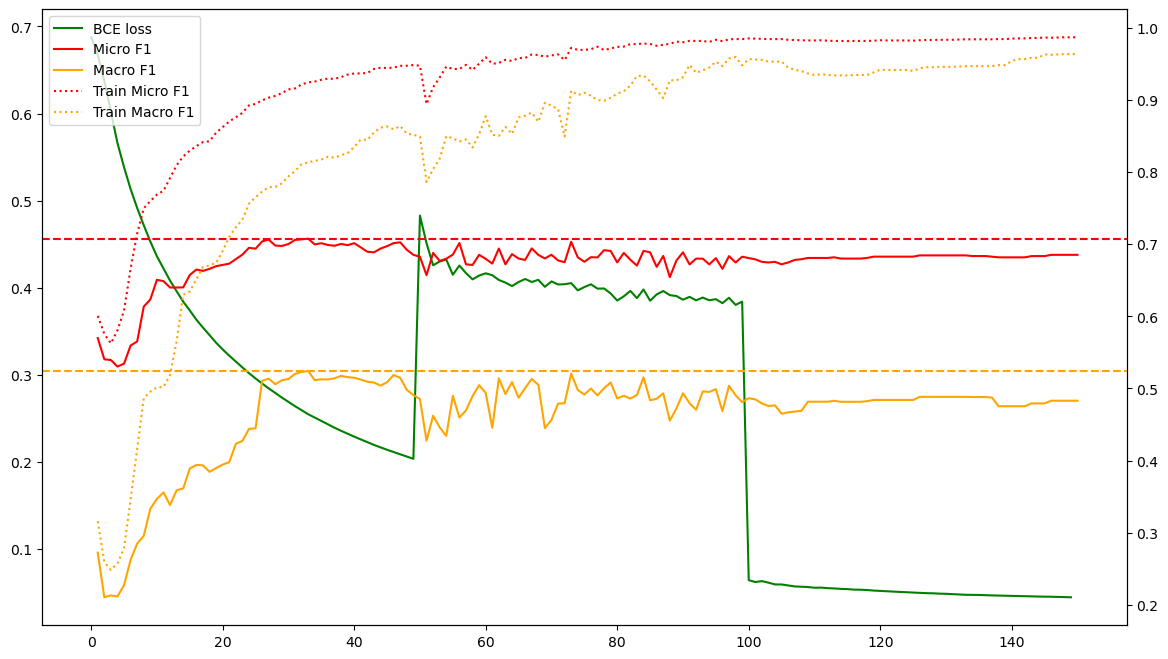

MicroF1:  0.707571804523468  @  32
MacroF1:  0.5241536498069763  @  32
MacroF1:  0.5241536498069763  @  32


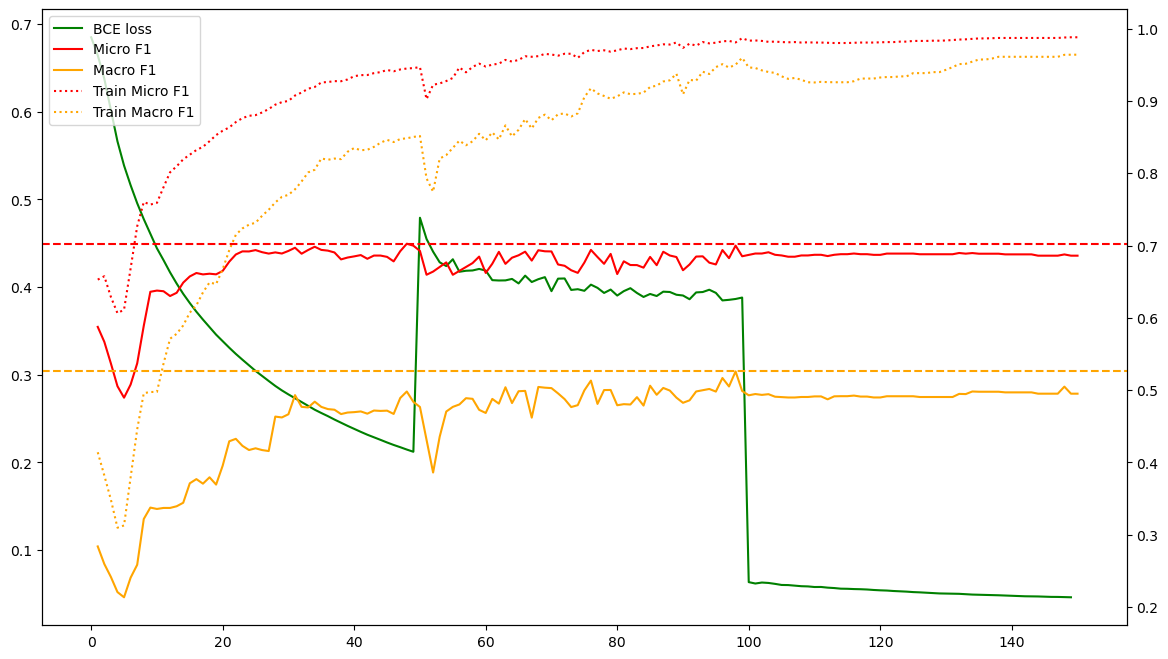

MicroF1:  0.7024901509284973  @  47
MacroF1:  0.5257821679115295  @  97
MacroF1:  0.4979702830314636  @  47


In [15]:
for log_dict in metrics:
    TrainerA.plot_metrics(log_dict, 1)

In [16]:
with open('metrics_contrast.pickle', 'wb') as f:
    pickle.dump(metrics, f)